In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import joblib
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from utils.reliability_visualizer import ReliabilityVisualizer

from utils.grace_classifier import GRACEClassifier

df_grace = pd.read_excel("dataset/data_validation.xlsx")

# df_grace=data_frame.loc[:,['Idade', 'FC_admissao', 'PAS_admissao', 'AntecedentesdePCI',  'Creatininaadmissao', 'Killip_entrada', 'Troponin_admissao', 'STEMI', 'Morte']]

In [2]:

# Instantiate the classifier
grace_classifier = GRACEClassifier()

def make_prediction(row):
    return grace_classifier.predict(
        age=row['Idade'],
        heart_rate=row['FC_admissao'],
        systolic_bp=row['PAS_admissao'],
        creatinine=row['Creatininaadmissao'],
        killip_class=row['Killip_maximo'],
        cardiac_arrest=row['Killip_entrada'],
        st_deviation=row['STEMI'],
        elevated_markers=row['Troponin_admissao']
    )

# Apply predictions to the dataset
df_grace['Predicted'] = df_grace.apply(make_prediction, axis=1)


y_true = df_grace['Morte']
y_pred = df_grace['Predicted']

confusion_matrix(y_true, y_pred)

#[TN FP]
#[FN TP]


array([[60, 34],
       [ 7, 36]])

# Pointwise DBSCAN

In [3]:
###########################################################
# Load Classifier and Data
###########################################################
pipeline = joblib.load('lr_pipeline_classifier.pkl')   # TODO: Just to make the data scaling 
training_data = pd.read_excel("dataset/data_train.xlsx")

y_train = training_data['Morte']
X_train = training_data.drop(columns=['Morte'])

X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

In [4]:
###########################################################
# Grid search DBSCAN Parameters
###########################################################

eps_values = np.linspace(0.01, 0.5, 20)
min_samples_values = range(2, 10, 2)

results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_train_preprocessed)
        
        labels = dbscan.labels_
        n_clusters = len(set(labels) - {-1})
        n_noise = list(labels).count(-1)
        
        if n_clusters > 0:
            cluster_sizes = [np.sum(labels == label) for label in set(labels) if label != -1]
            max_samples = max(cluster_sizes)
        else:
            max_samples = 0
        
        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "max_samples": max_samples
        })

results_df = pd.DataFrame(results)

best_params = results_df.loc[results_df['n_clusters'].idxmax()]
best_eps = best_params['eps']
best_min_samples = best_params['min_samples']
best_max_samples = best_params['max_samples']

print("Best Parameters to Maximize Clusters:")
print(f"eps: {best_eps}")
print(f"min_samples: {best_min_samples}")
print(f"max_samples: {best_max_samples}")

Best Parameters to Maximize Clusters:
eps: 0.035789473684210524
min_samples: 2.0
max_samples: 33.0


In [5]:
###########################################################
# Train DBSCAN
###########################################################
eps_value = 0.035789473684210524
min_samples_value = 2

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan.fit(X_train_preprocessed)

core_samples_mask = dbscan.labels_ != -1  # Exclude noise (-1)
core_points = X_train_preprocessed[core_samples_mask]
core_labels = dbscan.labels_[core_samples_mask]

print(f"Number of clusters (excluding noise): {len(set(core_labels))}")
print(f"Number of core points: {len(core_points)}")

Number of clusters (excluding noise): 118
Number of core points: 372


In [6]:
###########################################################
# Reliability Calculation with DBSCAN
###########################################################
def calculate_reliability_with_dbscan(new_instance, core_points, core_labels, dbscan, min_cluster_units):
    """
    Calculate reliability of a new instance based on DBSCAN clusters.

    Parameters:
    - new_instance: Preprocessed new instance.
    - core_points: Core points identified by DBSCAN.
    - core_labels: Cluster labels for core points.
    - dbscan (DBSCAN): Trained DBSCAN model on preprocessed training data.
    - min_cluster_units (int): Minimum number of points required for full reliability.

    Returns:
    - reliability_score: Reliability score based on cluster size.
    - in_cluster: Boolean indicating if the instance is part of a cluster.
    """
    # Find the nearest core point and its distance
    nbrs = NearestNeighbors(n_neighbors=1).fit(core_points)
    distance_to_core_point, nearest_core_idx = nbrs.kneighbors(new_instance.reshape(1, -1))
    nearest_core_idx = nearest_core_idx[0][0]  # Index of the nearest core point
    nearest_label = core_labels[nearest_core_idx]  # Cluster label of the nearest core point

    # Check if the new instance is in a cluster
    if nearest_label == -1 or distance_to_core_point[0][0] > dbscan.eps:
        return 0, False

    # Size of Cluster
    cluster_size = np.sum(core_labels == nearest_label)

    # Reliability
    reliability_score = min(cluster_size / min_cluster_units, 1.0)
    return reliability_score, True


def classify_and_check_reliability_dbscan(new_data, pipeline, core_points, core_labels, dbscan, min_cluster_units):
    """
    Predicts the class, determines cluster membership, and calculates reliability.

    Parameters:
    - new_data (pd.DataFrame): DataFrame with the same columns as training data.
    - pipeline (Pipeline): The loaded pipeline for preprocessing and classification.
    - core_points: Core points identified by DBSCAN.
    - core_labels: Cluster labels for core points.
    - dbscan: Trained DBSCAN model.
    - min_cluster_units (int): Minimum number of points required for full reliability.

    Returns:
    - dict: Contains prediction, cluster membership, and reliability score.
    """

    new_data_preprocessed = pipeline.named_steps['preprocessor'].transform(new_data)


    # Using Grace:
    # predicted_label = pipeline.named_steps['classifier'].predict(new_data_preprocessed)[0]

    new_data_row = new_data.iloc[0]  # Extract the first (and only) row


    predicted_label = grace_classifier.predict(
                        age=new_data_row['Idade'],
                        heart_rate=new_data_row['FC_admissao'],
                        systolic_bp=new_data_row['PAS_admissao'],
                        creatinine=new_data_row['Creatininaadmissao'],
                        killip_class=new_data_row['Killip_maximo'],
                        cardiac_arrest=new_data_row['Killip_entrada'],
                        st_deviation=new_data_row['STEMI'],
                        elevated_markers=new_data_row['Troponin_admissao']
                    )


    # Calculate reliability
    reliability_score, in_cluster = calculate_reliability_with_dbscan(
        new_data_preprocessed[0], core_points, core_labels, dbscan, min_cluster_units
    )

    return {
        "predicted_label": predicted_label,
        "reliability_score": reliability_score,
        "in_cluster": in_cluster
    }

In [7]:
###########################################################
# Load Validation Data and Test
###########################################################
validation_data = pd.read_excel("dataset/data_validation.xlsx")
results = []

################
#### Adjust
min_cluster_units = 9  # Minimum points for full reliability

for _, instance in validation_data.iterrows():
    true_label = instance['Morte']
    instance_df = pd.DataFrame([instance.drop(labels=['Morte'])])
    result = classify_and_check_reliability_dbscan(
        instance_df, pipeline, core_points, core_labels, dbscan, min_cluster_units
    )
    result['true_label'] = true_label
    results.append(result)

# Filter results where reliability_score > 0
filtered_results = [result for result in results if result['reliability_score'] > 0]
# filtered_results

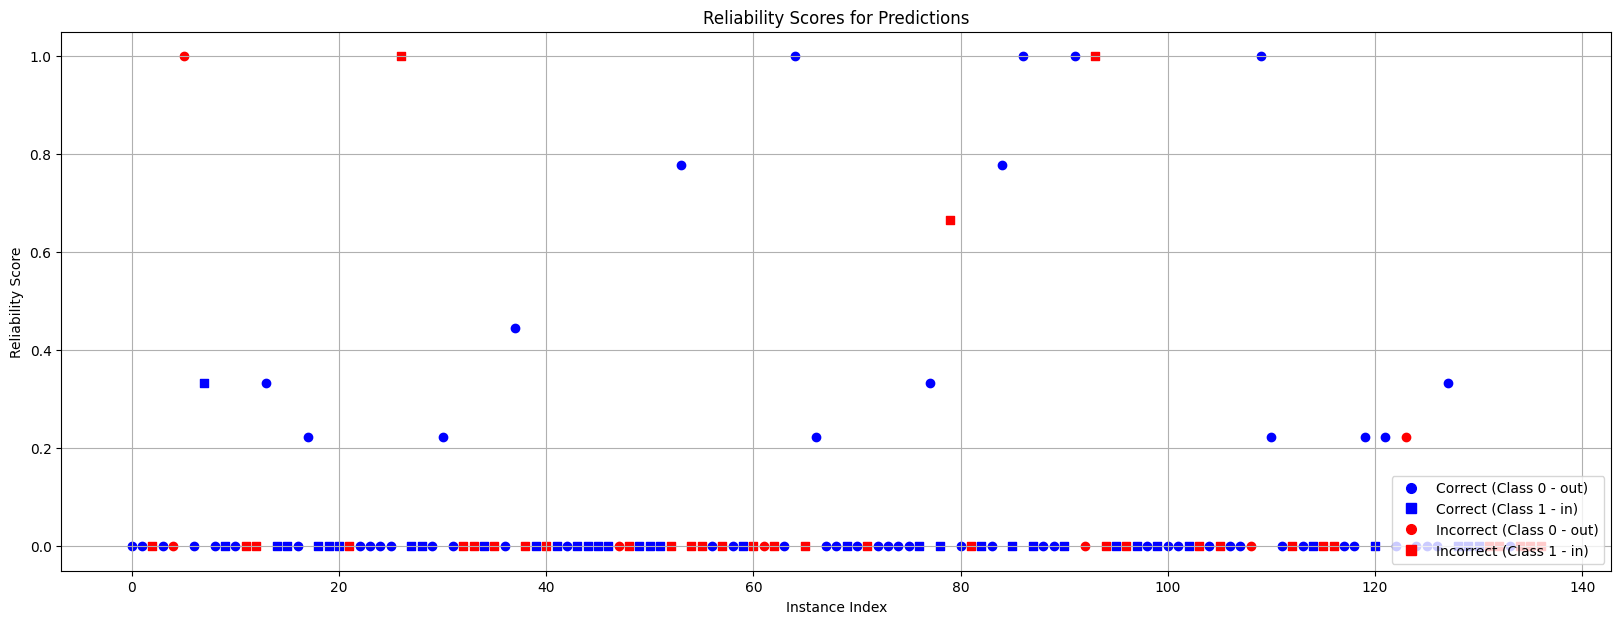

In [8]:
###########################################################
# Results and Visualization
###########################################################
results_df = pd.DataFrame(results)

visualizer = ReliabilityVisualizer(results_df=results_df)
visualizer.plot_reliability_scores((20, 7))

In [9]:
reliability_table_df = visualizer.get_reliability_table_5()

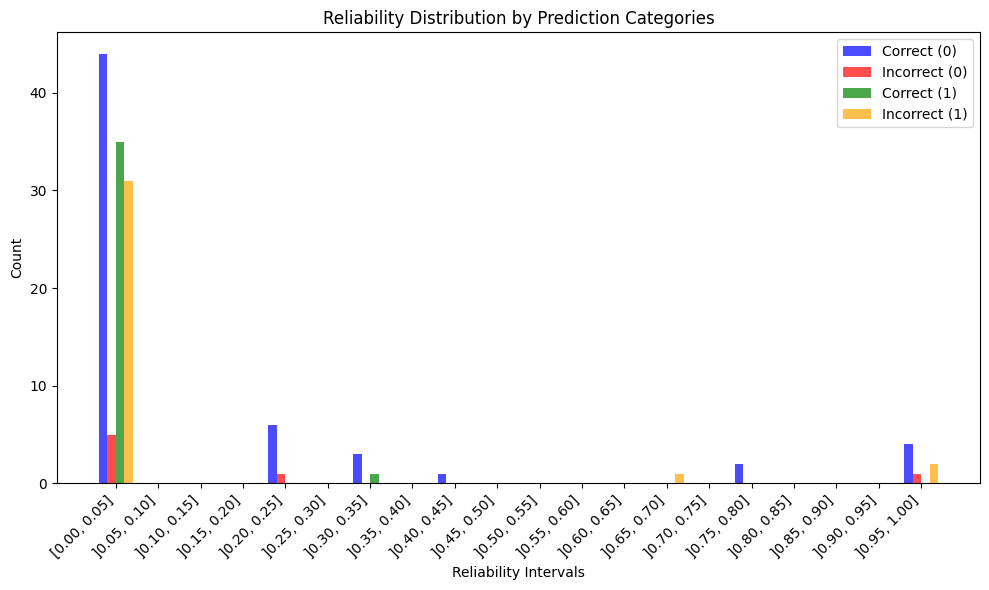

In [10]:
visualizer.plot_table_graph(reliability_table_df)

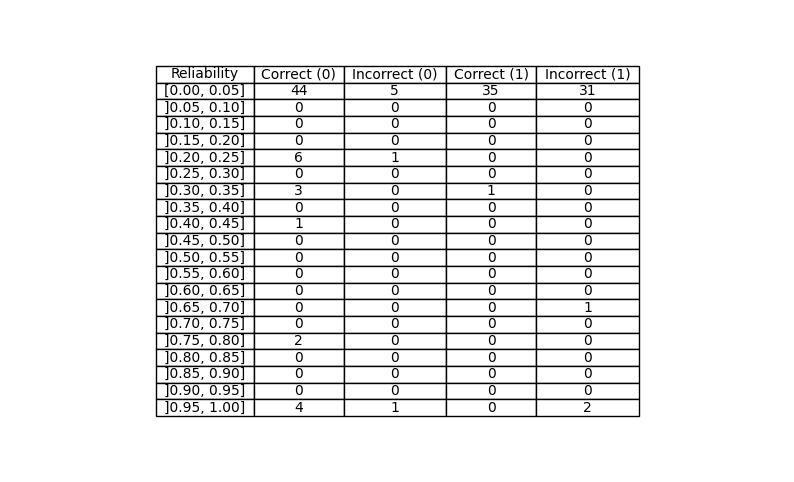

In [11]:
visualizer.plot_table_image(reliability_table_df)

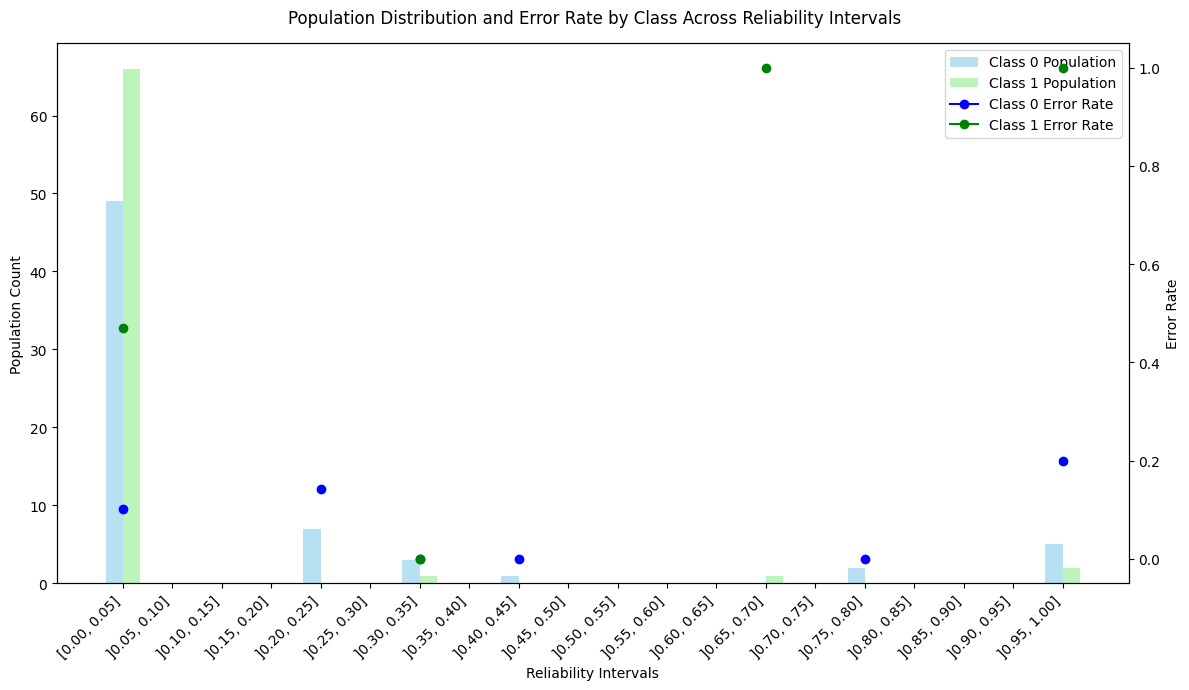

In [12]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_df)

### 10

In [13]:
reliability_table_10_df = visualizer.get_reliability_table_10()
print(reliability_table_10_df)

    Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0  [0.00, 0.10]           44              5           35             31
1  ]0.10, 0.20]            0              0            0              0
2  ]0.20, 0.30]            6              1            0              0
3  ]0.30, 0.40]            3              0            1              0
4  ]0.40, 0.50]            1              0            0              0
5  ]0.50, 0.60]            0              0            0              0
6  ]0.60, 0.70]            0              0            0              1
7  ]0.70, 0.80]            2              0            0              0
8  ]0.80, 0.90]            0              0            0              0
9  ]0.90, 1.00]            4              1            0              2


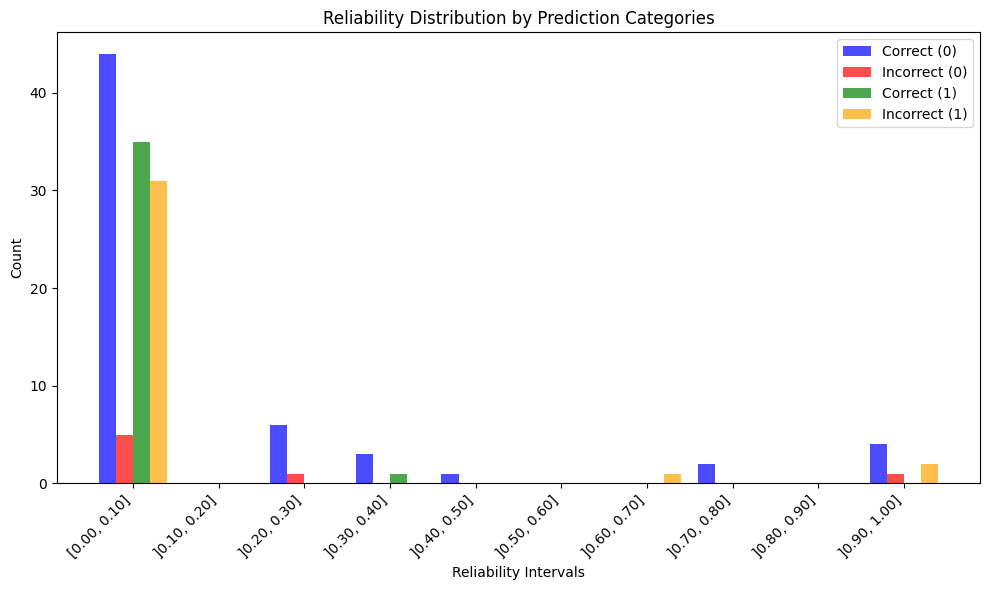

In [14]:
visualizer.plot_table_graph(reliability_table_10_df)

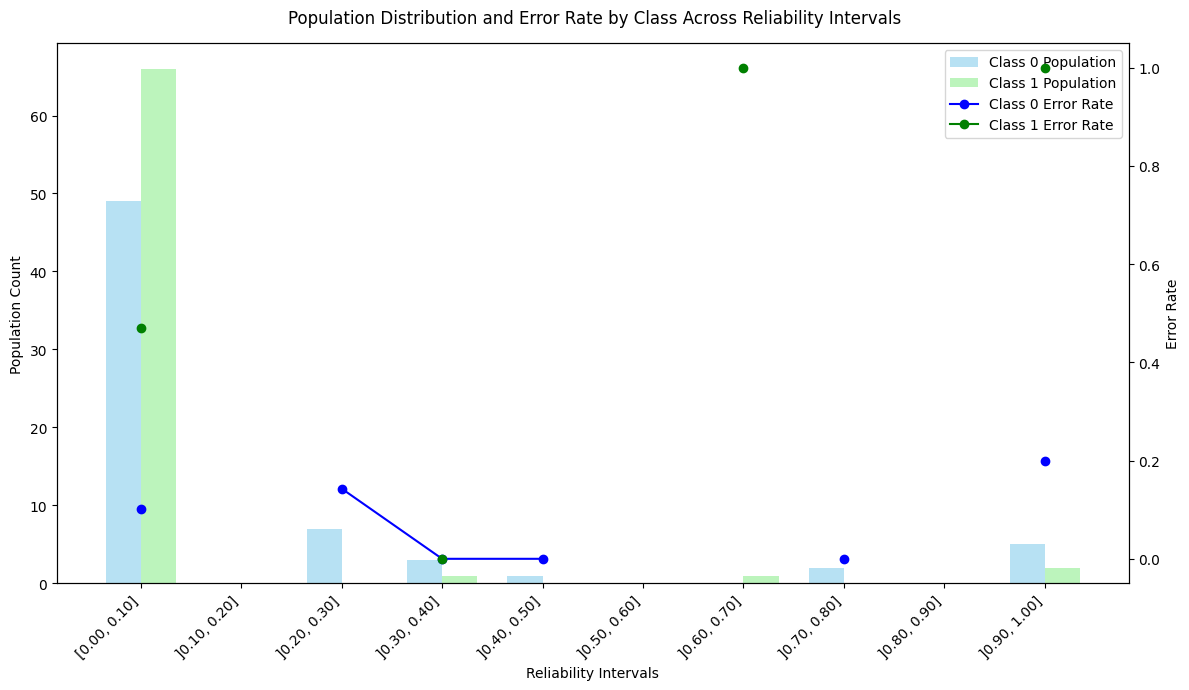

In [15]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_10_df)

Sample reliability interval assignment:
   reliability_score reliability_interval
0           0.000000        (-0.001, 0.1]
1           0.000000        (-0.001, 0.1]
2           0.000000        (-0.001, 0.1]
3           0.000000        (-0.001, 0.1]
4           0.000000        (-0.001, 0.1]
5           1.000000           (0.9, 1.0]
6           0.000000        (-0.001, 0.1]
7           0.333333           (0.3, 0.4]
8           0.000000        (-0.001, 0.1]
9           0.000000        (-0.001, 0.1]


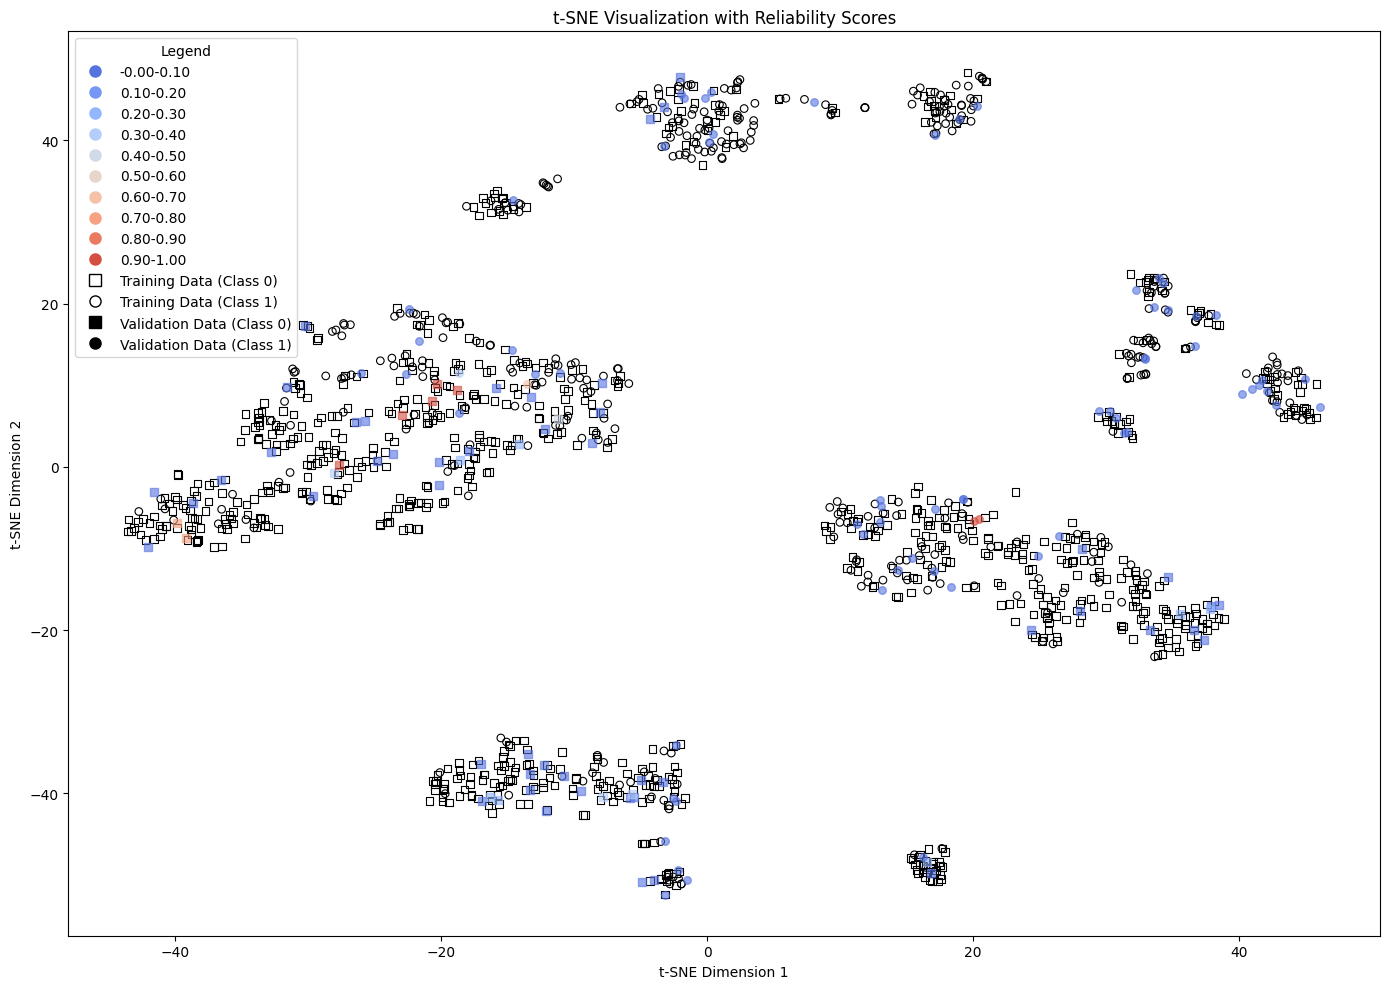

In [16]:
visualizer.plot_tsne_with_reliability(
    X_train_preprocessed, validation_data, y_train, pipeline
)